***
# Logistic Regression and Support Vector Machines
MSDS 7331-407   
*Jenna Ford, Edward Fry, Christian Nava, and Jonathan Tan* 
***

<a id = 'Section_A'></a>

## Table of Contents

<a href='#Section_0'> 0. Introduction </a>  
<a href='#Section_1'> 1. Preparation and Dataset Loading </a>  
<a href='#Section_2'> 2. Data Cleansing (Lab 1) </a>  
<a href='#Section_3'> 3. Models </a>  
<a href='#Section_3_a'> &nbsp;&nbsp;&nbsp; a. Futher Data Preparation for Logistic Regression and SVM </a>  
<a href='#Section_3_b'> &nbsp;&nbsp;&nbsp; b. Logistic Regression</a>  
<a href='#Section_3_c'> &nbsp;&nbsp;&nbsp; c. Support Vector Machine </a>  
<a href='#Section_4'> 4. Model Advantages </a>  
<a href='#Section_5'> 5. Feature Importance</a>  
<a href='#Section_6'> 6. Interpretation Support Vectors </a>  

<!-- <a href='#Section_4_a'> &nbsp;&nbsp;&nbsp; a. Missing Values </a>  --> 
<!-- <a href='#Section_4_c_i'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; i. Cross Street </a>    --> 

<a id = 'Section_0'></a>

## 0. Introduction

For this project our group will continue to use the Los Angeles arrest incidents dataset with arrest incidents dating back to 2010, which can be found [here](https://data.lacity.org/A-Safe-City/Arrest-Data-from-2010-to-Present/yru6-6re4). This dataset contains information about the date, time and location of the incident, demographic data of the person arrested, and information about the type of incident. 

We will be using multi-nomial Logistic Regression and Support Vector Machines to classify the variable `Arrest Type` (Felony, Misdemeanor, Infraction, Other). We feel that being able to classify arrest type could help in prioritizing dispatch calls, especially when there are more calls than officers available to respond. We assume that arrest type is an indicator of the severity of the incident. It is also worth noting that most of the data available for the classification would be available to the dispatcher. For example, someone placing a call to 911 would most likely have a basic description of the offender such as gender, approximate age and ethnicity. The caller would also know the location of the incident and have a brief description of the situation. 

We will use a variety of cross validation techniques and adjust model parameters to fine-tune our classification models. Model effectiveness will be measured using accuracy. A successful model would ideally exceed the ability of a dispatcher to correctly identify the arrest type. However, we do not have data available for this. To be considered effective, the model should significantly outperform random chance (25%), so we will use accuracy of 75% as the cut-off for identifying if the model is successful.

<a href='#Section_A'> Back to top </a>
<a id = 'Section_1'></a>

## 1. Preparation and Dataset Loading

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Creating training and test sets
import sklearn

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#training/test split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, ShuffleSplit

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# here we can change some of the parameters interactively
from ipywidgets import widgets as wd
from sklearn.model_selection import cross_val_score, cross_validate

#for weights standardization
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

# Support vector machines
from sklearn.svm import SVC

import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [3]:
# Constants
DATAPATH_BASE = 'https://machinelearningi.blob.core.windows.net/group-project/'
DATAPATH_SAS_TOKEN = '?sv=2019-02-02&ss=bfqt&srt=sco&sp=rwdlacup&se=2020-04-27T11:12:37Z&st=2020-01-23T04:12:37Z&spr=https&sig=jpIpjrp8dIg9eyUyPpmgTe5yj9i1ZoCSru5kBVHcUO8%3D'
DATAPATH_FILENAME = 'Arrest_Data_from_2010_to_Present.csv'
DATAPATH_SMALL_FILENAME = 'Arrest_Data_from_2010_to_Present_Small.csv'

# Fully qualified paths ready to use
DATA_SOURCE = "".join([DATAPATH_BASE, DATAPATH_FILENAME, DATAPATH_SAS_TOKEN])

# Options
pd.set_option('float_format', '{:.2f}'.format)  # Reign in the scientific notation for reasonable values

# Load data for analysis; only read if needed because the import can take a long time
try:
    if len(df.index) < 1:
        df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe was empty
except:   
    df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe did not exist
    

In [4]:
df = df_raw

print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 1,324,973 rows and 17 columns


<a href='#Section_A'> Back to top </a>
<a id = 'Section_2'></a>

## 2. Data Cleansing (Lab 1)

The data cleansing steps performed below are repeated from Lab 1.

In [5]:
# Time - filter out 0 and missing
df = df[df['Time'] != 0]
df['Time'] = df['Time'].astype(str) 
df = df[df['Time'] != 'nan']

# Time - Convert float to string. Get rid of decimals. Replace missing or invalid values with '0000'.
df['Time'] = df['Time'].astype(str).str.split(".", expand = True)[0].replace(to_replace = ['2400','nan'], value = '0000') 

# Time - Fill time column with leading zeros to have 4 characters total
df['Time'] = df['Time'].apply(lambda x: '{0:0>4}'.format(x))

# Time - Add colon to Time values by converting attribute to a datetime variable 
df['Time'] = pd.to_datetime(df['Time'], format = '%H%M').dt.time

# Age - Drop the observations where Age is less than 16
df.drop(df[df['Age'] < 16].index, inplace = True) 

# Arrest Type Code - Drop the observations where Arrest Type Code = 'D'
df.drop(df[df['Arrest Type Code'] == 'D'].index, inplace = True) 

# Descent Code - Re-classify any descent not in (B,H,O,W) into 0
descent_list = ['B','H','O','W']
df['Descent Code'] = np.where(np.isin(df['Descent Code'],descent_list),df['Descent Code'],'O')

# Get hour
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

# Convert Arrest Date to datetime
df['Arrest Date'] = pd.to_datetime(df['Arrest Date'])

# Extract year, month, and day of week and add to dataframe as new attributes
df['arrest_year']= df['Arrest Date'].dt.year
df['arrest_month']= df['Arrest Date'].dt.month
df['arrest_day_of_week'] = df['Arrest Date'].dt.weekday_name

# remove unecessary columns
df.drop(['Cross Street','Charge Description','Charge','Charge Group Description','Time',
         'Arrest Date','Report ID','Address','Area Name'], axis=1, inplace=True)

# Change data types
df['Age'] = df['Age'].astype(np.int8)
df['Reporting District'] = df['Reporting District'].astype(np.str)
df['Area ID'] = df['Area ID'].astype(np.str)
df['Charge Group Code'] = df['Charge Group Code'].astype(np.str)
df['Hour'] = df['Hour'].astype(np.str)
df['arrest_year'] = df['arrest_year'].astype(np.str)
df['arrest_month'] = df['arrest_month'].astype(np.str)
df['arrest_day_of_week'] = df['arrest_day_of_week'].astype(np.str)

# print clean dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1277176 entries, 0 to 1324972
Data columns (total 12 columns):
Area ID               1277176 non-null object
Reporting District    1277176 non-null object
Age                   1277176 non-null int8
Sex Code              1277176 non-null object
Descent Code          1277176 non-null object
Charge Group Code     1277176 non-null object
Arrest Type Code      1277176 non-null object
Location              1277176 non-null object
Hour                  1277176 non-null object
arrest_year           1277176 non-null object
arrest_month          1277176 non-null object
arrest_day_of_week    1277176 non-null object
dtypes: int8(1), object(11)
memory usage: 118.1+ MB


In [7]:
print("The clean data set has {:,} rows and {:,} columns".format(*df.shape))

The clean data set has 1,277,176 rows and 12 columns


<a href='#Section_A'> Back to top </a>
<a id = 'Section_3'></a>

## 3. Models

<a id = 'Section_3_a'></a>

### a. Futher Data Preparation for Logistic Regression and SVM

All categorical variables need to be dummy encoded. For example, if a variable has n different categories, we need to split this out to n-1 different variables. The code below does this for the categorical variables used in the model. The target variable `Arrest Type Code` is transformed to range from 0-3 instead of alphabetical letters representing the arrest type. Also, `Age` was bucketed into 10 year increments.

In [8]:
# Encode Arrest Type Code as Categorical
cleanup_arrest = {"Arrest Type Code": {"F": 0, "M": 1, "I": 2, "O":3}}
df.replace(cleanup_arrest,inplace=True)

# Create buckets for Age
df['age_range'] = pd.cut(df.Age,[16,25,35,45,55,65,75,1e6],4,labels=[0,1,2,3,4,5,6]) # this creates a new variable
df['age_range'] = df.age_range.astype(np.int)

# Perform one-hot encoding of the categorical data "Descent Code"
tmp_df = pd.get_dummies(df['Descent Code'],prefix='Descent',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Replace the current Sex atribute with something slightly more intuitive and readable
df['IsMale'] = df['Sex Code']=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Perform one-hot encoding of the categorical data "DOW"
tmp_df = pd.get_dummies(df['arrest_day_of_week'],prefix='DOW',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Area ID"
tmp_df = pd.get_dummies(df['Area ID'],prefix='Area',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Charge Group Code"
tmp_df = pd.get_dummies(df['Charge Group Code'],prefix='Charge',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Hour"
tmp_df = pd.get_dummies(df['Hour'],prefix='Hour',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(df['arrest_month'],prefix='Month',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

Next, we perform a check to see if there are any Charge Group Codes that have only one Arrest Type Code. For example, if the Charge Group Code referring to Murder is always associated with a Felony, we should not include these observations in the model. This would overinflate the model's accuracy.

In [9]:
grps = df.groupby(['Charge Group Code','Arrest Type Code']).size()
grps1 = grps.groupby('Charge Group Code').count()
grps1[grps1 == 1]

Charge Group Code
25.0    1
3.0     1
99.0    1
dtype: int64

Below, we remove any observations with Charge Group Codes of 3 (Robbery - Felony), 25 (Federal Offenses - Felony) or 99 (no description was provided in the dataset - Felony) since these are always associated with the same Arrest Type Code. We also remove any observations where no Charge Group Code was specified. 107,942 observations were removed from the dataset by filtering out these Charge Group Codes. The resulting dataset has 1,169,234 observations.

In [10]:
#create another dataset for binary classification & SVM later
df_binary = df
df_svm = df

#filter charge group codes 
charge_codes_exclude= ['3.0','25.0','99.0','nan']
df = df[~df['Charge Group Code'].isin(charge_codes_exclude) ]

print("The filtered data set has {:,} rows and {:,} columns".format(*df.shape))

The filtered data set has 1,169,234 rows and 105 columns


Now that the variables are all properly encoded, we remove the original variables from the dataset. We also remove `Reporting District` and `Location`. `Reporting District` has 1351 unique values and would be too cumbersome to include in our models. We instead use `Area ID`, where each Area ID is comprised of multiple Reporting Districts. We also remove `Location` which is GPS coordinates for the location of the incident, again in favor of `Area ID`.

Information about the resulting dataframe is printed for verification and the first 5 records are printed out.

In [11]:
df.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Location','arrest_year','Age','Hour','arrest_month'], axis=1, inplace=True)
df_logreg = df
df_logreg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169234 entries, 3 to 1324972
Data columns (total 94 columns):
Arrest Type Code    1169234 non-null int64
age_range           1169234 non-null int32
Descent_H           1169234 non-null uint8
Descent_O           1169234 non-null uint8
Descent_W           1169234 non-null uint8
IsMale              1169234 non-null int32
DOW_Monday          1169234 non-null uint8
DOW_Saturday        1169234 non-null uint8
DOW_Sunday          1169234 non-null uint8
DOW_Thursday        1169234 non-null uint8
DOW_Tuesday         1169234 non-null uint8
DOW_Wednesday       1169234 non-null uint8
Area_10             1169234 non-null uint8
Area_11             1169234 non-null uint8
Area_12             1169234 non-null uint8
Area_13             1169234 non-null uint8
Area_14             1169234 non-null uint8
Area_15             1169234 non-null uint8
Area_16             1169234 non-null uint8
Area_17             1169234 non-null uint8
Area_18             1169234

In [12]:
df.head()

Arrest Type Code  age_range  Descent_H  Descent_O  Descent_W  IsMale  \
3                  0          1          0          1          0       1   
5                  0          2          0          0          1       1   
10                 2          0          0          0          1       0   
11                 1          1          1          0          0       1   
13                 1          0          1          0          0       1   

    DOW_Monday  DOW_Saturday  DOW_Sunday  DOW_Thursday  ...  Month_11  \
3            0             0           0             0  ...         0   
5            0             0           0             0  ...         0   
10           0             1           0             0  ...         1   
11           0             0           0             0  ...         1   
13           0             0           0             0  ...         1   

    Month_12  Month_2  Month_3  Month_4  Month_5  Month_6  Month_7  Month_8  \
3          0        0        0        1        0        0        0        0   
5          0        0        0        1        0        0        0        0   
10         0        0        0        0        0        0        0        0   
11         0        0        0        0        0        0        0        0   
13         0        0        0        0        0        0        0        0   

    Month_9  
3         0  
5         0  
10        0  
11        0  
13        0  

[5 rows x 94 columns]

#### Correlation Matrix
Next we look at the correlation matrix for our encoded features. Two explanatory variables with high correlation between each other should not both be included in the model. In the plot below, axis labels have been omitted for clarity, but it does not hurt the visualization because there is very low correlation between the many encoded features.  The yellow line down the diagonal represents where each feature is compared to itself, so, of course, those correlations are 1 (and can be ignored because they are between the same variable). We do not see the need to remove any variables for multicollinearity reasons.

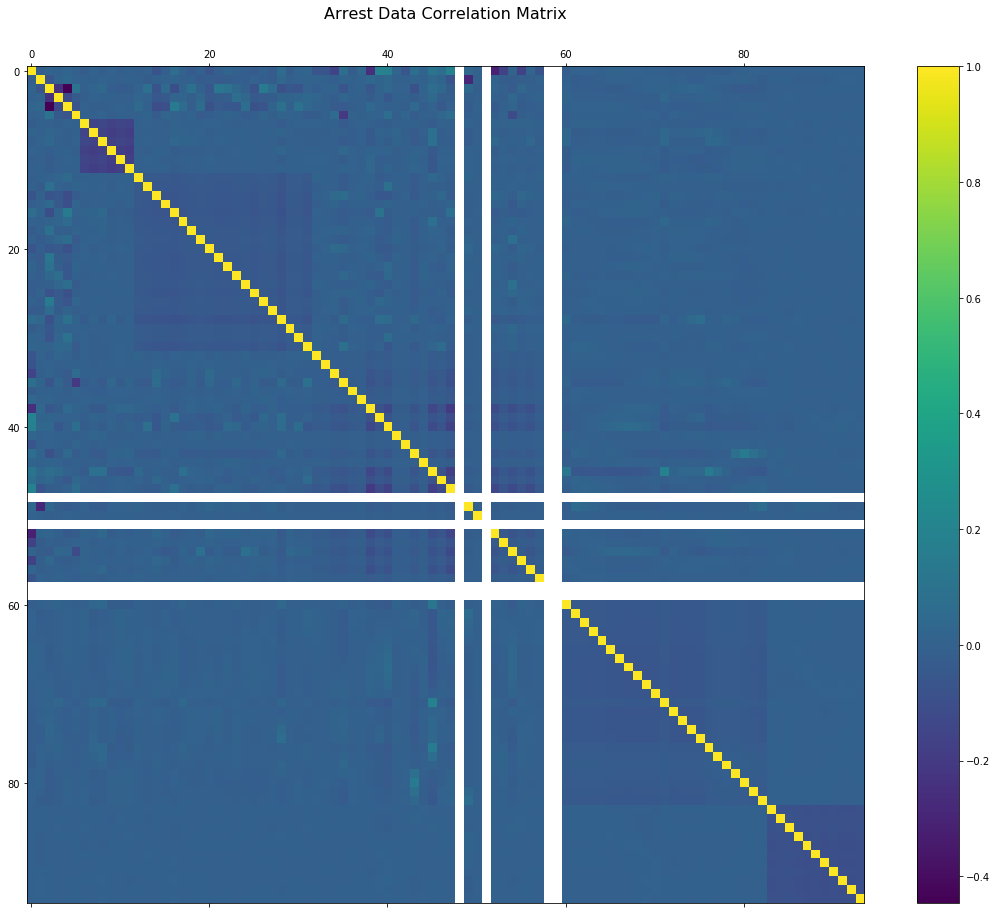

In [13]:
# Take a look at the correlations between the many features in the data set
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
cb = plt.colorbar()
plt.title('Arrest Data Correlation Matrix', fontsize=16);

<a href='#Section_A'> Back to top </a>
<a id = 'Section_3_b'></a>

### b. Logistic Regression

The section of code below sets up the frame for the logistic regression model. The target `Arrest Type Code` is identified as `y` and all other variables are assigned as explanatory variables `X`. We will be running multi-nomial Logistic Regression models since we have 4 Arrest Type Codes that we are trying to predict: Felony, Misdemeanor, Infraction, and Other.

In [14]:
# we want to predict the X and y data as follows:
if 'Arrest Type Code' in df_logreg:
    y = df_logreg['Arrest Type Code'].values # get the labels we want
    del df_logreg['Arrest Type Code'] # get rid of the class label
    X = df_logreg.values # use everything else to predict!

We will use 3 different cross validation techniques to split the data and compare performance.
1. ShuffleSplit - use an 80%/20% training/test split. 3 iterations will be run. 
2. StratifiedShuffleSplit - use an 80%/20% training/test split. 3 iterations will be run. Here, the splits maintain the same percentages of each Arrest Type Code as the original dataset.
3. StratifiedKFold - dataset is split into 10 different groups and one group is left out each time. The splits maintain the same percentages of each Arrest Type Code as the original dataset.

In [15]:
#Create the cross validation objects to be used in models
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2,random_state=1234)
cv_object1 = StratifiedShuffleSplit(n_splits=num_cv_iterations, test_size=0.2, random_state=1234)
cv_object2 = StratifiedKFold(n_splits=10, random_state=1234)
                         
print(cv_object)
print(cv_object1)
print(cv_object2)

ShuffleSplit(n_splits=3, random_state=1234, test_size=0.2, train_size=None)
StratifiedShuffleSplit(n_splits=3, random_state=1234, test_size=0.2,
            train_size=None)
StratifiedKFold(n_splits=10, random_state=1234, shuffle=False)


The code below creates a function to run the ShuffleSplit and the StratifiedShuffleSplit models to streamline testing multiple instances of each. The dataset is first split into train and test, then the explanatory variables are scaled. We do the scaling after the split so that we are not influencing scaling on observations in the test set. Finally, we fit the model with the training set and predict with the test set.

In [16]:
def shufflesplits(estimator, cross_val_object):
    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cross_val_object.split(X,y): 
        X_train = X[train_indices]
        y_train = y[train_indices]

        X_test = X[test_indices]
        y_test = y[test_indices]

        scl_obj = StandardScaler()
        scl_obj.fit(X_train)

        X_train_scaled = scl_obj.transform(X_train) # apply to training
        X_test_scaled = scl_obj.transform(X_test)

        # train the reusable logisitc regression model on the training data
        estimator.fit(X_train_scaled,y_train)  # train object
        y_hat = estimator.predict(X_test_scaled) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        print("====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y_test,y_hat))
        print("precision", mt.precision_score(y_test,y_hat,average='weighted')) 
        print("recall", mt.recall_score(y_test,y_hat,average='weighted')) 
        print("confusion matrix\n",mt.confusion_matrix(y_test,y_hat))
        iter_num+=1

#### ShuffleSplit
First, we run the ShuffleSplit cross validation. We are using 2 options that are important for multi-nomial logistic regression: multi-class='multinomial' and class_weight='balanced'. Our data is not balanced between values of `Arrest Type Code`. 33.01% of the data are Felonies, 62.55% are Misdemeanors, 2.23% are Infractions and 2.22% are Other. Using class-weight='balanced' adjusts the weights to correspond to the occurrence of values of `Arrest Type Code` such that more emphasis will be placed on values of `Arrest Type Code` that occur most frequently. Here, more emphasis will be placed on Misdemeanor than Felony, and more emphasis will be placed on Felony than Infraction and Other.

Accuracy, precision, recall and the confusion matrix are printed out for each iteration of the model. Accuracy averages out to 64.43% over these 3 iterations. The most important incidents to correctly identify are Felonies. It is concerning here the large number of misclassifications of Felonies, especially those misclassified to Other.

For all models, the confusion matrices print in this order: Felony, Misdemeanor, Infraction, Other.

In [14]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', solver='newton-cg',random_state=1234, class_weight='balanced')
shufflesplits(lr_clf,cv_object)

====Iteration 0  ====
accuracy 0.6437628021740711
precision 0.8287119391430836
recall 0.6437628021740711
confusion matrix
 [[57571  8051   426 11453]
 [16957 83275 21236 24483]
 [  238   263  4578   101]
 [    1    96     0  5118]]
====Iteration 1  ====
accuracy 0.6445667466334826
precision 0.8296769837944548
recall 0.6445667466334826
confusion matrix
 [[57645  7931   546 11239]
 [17019 83448 21172 24534]
 [  182   322  4557    91]
 [    0    80     1  5080]]
====Iteration 2  ====
accuracy 0.6447762853489675
precision 0.8286721862701164
recall 0.6447762853489675
confusion matrix
 [[57548  8098   467 11286]
 [17024 83541 21045 24490]
 [  206   268  4538    93]
 [    0    91     0  5152]]
Wall time: 27min 30s


#### StratifiedShuffleSplit
Next, we run the StratifiedShuffleSplit cross validation using the same logistic regression model as before. Accuracy averages out to 64.49% over these 3 iterations, which is slightly higher than the ShuffleSplit cross validation.

In [15]:
%%time
shufflesplits(lr_clf,cv_object1)

====Iteration 0  ====
accuracy 0.644211813707253
precision 0.8294224539408316
recall 0.644211813707253
confusion matrix
 [[57340  8042   463 11341]
 [16792 83608 21361 24500]
 [  242   281  4585    95]
 [    0    83     0  5114]]
====Iteration 1  ====
accuracy 0.6436943813690148
precision 0.8288521835819256
recall 0.6436943813690148
confusion matrix
 [[57272  8086   475 11353]
 [16879 83539 21149 24694]
 [  231   284  4590    98]
 [    0    72     0  5125]]
====Iteration 2  ====
accuracy 0.646948645909505
precision 0.8297194328593136
recall 0.646948645909505
confusion matrix
 [[57551  8039   453 11143]
 [16801 84081 20861 24518]
 [  227   331  4541   104]
 [    1    82     0  5114]]
Wall time: 23min 24s


#### StratifiedKFold
For StratifiedKFold cross validation we create a separate function, which is slightly condensed. The function still splits the data into train and test datasets, and scales the explanatory variables after the split has been made. 

In [12]:
def log_reg(estimator,cross_val_object):
    yhat=np.zeros(y.shape)
    std_scl = StandardScaler()

    # create the pipline
    piped_object = Pipeline([('scale', std_scl), ('logit_model', estimator)])

    # run the pipline corssvalidated
    for train, test in cross_val_object.split(X,y):
        piped_object.fit(X[train],y[train])  # train object
        yhat[test] = piped_object.predict(X[test])

    # it is a little odd getting trained objects from a  pipeline:
    trained_model_from_pipeline = piped_object.named_steps['logit_model']
    print("confusion matrix\n",mt.confusion_matrix(y,yhat))
    print("accuracy", mt.accuracy_score(y,yhat))
    print("precision", mt.precision_score(y,yhat,average='weighted'))
    print("recall", mt.recall_score(y,yhat,average='weighted'))

#### StratifiedKFold: solver='newton-cg'
For the first model of StratifiedKFold cross validation, we use the same model as before. Here we specify the penalty of 'l2' (which is the default). We will adjust various model parameters to see how they affect accuracy.

In [17]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286155  40425   2782  56567]
 [ 86907 404016 114733 125646]
 [  1141   2519  21866    490]
 [     6    447      1  25533]]
accuracy 0.6308147043277906
precision 0.823413354508481
recall 0.6308147043277906
Wall time: 1h 35min 47s


Below, we switch the penalty to 'none'. There are no other penalty options to choose from because solver 'newton-cg' only supports penalty 'l2' or 'none'. Accuracy is practically identical for both options of solver 'newton-cg'. It is interesting to note that the compute time increases by approximately 26 minutes.

In [18]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', solver='newton-cg',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286155  40425   2782  56567]
 [ 86909 404015 114733 125645]
 [  1141   2519  21866    490]
 [     6    447      1  25533]]
accuracy 0.630813849066996
precision 0.8234118830341388
recall 0.630813849066996
Wall time: 1h 56min 53s


#### StratifiedKFold: solver='lbfgs'
Now we change solver to 'lbfgs'. We first run the model with penalty='l2'.

In [19]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='l2', solver='lbfgs',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286159  40424   2782  56564]
 [ 86901 404024 114731 125646]
 [  1141   2520  21865    490]
 [     6    447      1  25533]]
accuracy 0.6308241121965321
precision 0.8234192710723752
recall 0.6308241121965321
Wall time: 13min 15s


Here we again use solver='lbfgs', but we switch the penalty to 'none'. Solver 'lbfgs' only supports penalty 'l2' or 'none'. Accuracy is again practically the same for both penalty options of solver 'lbfgs'. Using solver 'lbfgs' does reduce the compute time by over an hour and twenty-two minutes as compared to the previous two models.

In [20]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', solver='lbfgs',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286155  40424   2782  56568]
 [ 86907 404022 114728 125645]
 [  1141   2519  21866    490]
 [     6    447      1  25533]]
accuracy 0.6308198358925587
precision 0.8234155555505498
recall 0.6308198358925587
Wall time: 13min 19s


#### StratifiedKFold: solver='sag'
Now we change the solver to 'sag'. Using a penalty of 'l2' reduces the accuracy to 63.05%, compared to the 63.08% we have seen with other models.

In [21]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='l2', solver='sag',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286243  40349   2772  56565]
 [ 86959 403591 115043 125709]
 [  1141   2511  21874    490]
 [     6    446      1  25534]]
accuracy 0.6305341787871376
precision 0.823439162914933
recall 0.6305341787871376
Wall time: 43min 45s


Changing the penalty to 'none' increases the accuracy of the model to 63.09%, and it decreases the time from 44 minutes to 39 minutes.

In [22]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', solver='sag',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286137  40426   2803  56563]
 [ 86847 404137 114614 125704]
 [  1141   2530  21858    487]
 [     5    456      1  25525]]
accuracy 0.6308891120169273
precision 0.823440631208759
recall 0.6308891120169273
Wall time: 38min 45s


#### StratifiedKFold: solver='saga'
Below we try out 3 models for solver='saga'. These models test different options for penalty: 'l2', 'l1', and 'elasticnet'. We use l1_ratio=.5 for penalty='elasticnet', which signifies a combination of L1 and L2. Again, we see that changing the solver and penalty, does not significantly change the accuracy performance of the model. The only thing that does change significantly is the compute time.

In [23]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='l2', solver='saga',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286155  40426   2781  56567]
 [ 86907 404011 114733 125651]
 [  1141   2519  21866    490]
 [     6    447      1  25533]]
accuracy 0.6308104280238173
precision 0.8234113738354569
recall 0.6308104280238173
Wall time: 47min 1s


In [24]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', solver='saga',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286155  40425   2782  56567]
 [ 86909 404010 114733 125650]
 [  1141   2519  21866    490]
 [     6    447      1  25533]]
accuracy 0.6308095727630226
precision 0.8234111396984166
recall 0.6308095727630226
Wall time: 44min 37s


In [25]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', penalty='elasticnet', l1_ratio=.5, solver='saga',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286159  40426   2777  56567]
 [ 86906 404008 114737 125651]
 [  1141   2519  21866    490]
 [     6    447      1  25533]]
accuracy 0.630811283284612
precision 0.8234124717724207
recall 0.630811283284612
Wall time: 1h 11min 51s


#### StratifiedKFold: Changes in C
The following two blocks of code test different values for C using the 'lbfgs' solver. We use 'lbfgs' since this solver has been the fastest to compute and since the models all have very similar accuracies. We noticed that decreasing the `C` parameter to 1.5 decreased our compute time from 13 minutes 15 seconds from the fastest version of the model to 10 minutes and 36 seconds.

In [26]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', C=.5, penalty='l2', solver='lbfgs',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286161  40424   2781  56563]
 [ 86899 404041 114731 125631]
 [  1141   2518  21867    490]
 [     6    447      1  25533]]
accuracy 0.6308420726732202
precision 0.8234263681190657
recall 0.6308420726732202
Wall time: 11min 5s


In [27]:
%%time
lr_clf = LogisticRegression(multi_class='multinomial', C=1.5, penalty='l2', solver='lbfgs',random_state=1234, class_weight='balanced')
log_reg(lr_clf,cv_object2)

confusion matrix
 [[286159  40422   2781  56567]
 [ 86909 404015 114726 125652]
 [  1141   2519  21866    490]
 [     6    447      1  25533]]
accuracy 0.6308172701101747
precision 0.8234166091519051
recall 0.6308172701101747
Wall time: 10min 36s


#### Logistic Regression Winning Model

`Table 1` shows performance for each model run. We have chosen the StratifiedKFold model using solver='lbgfs', penalty='l2' and C='0.5' as the winning model. This is not the model with the highest accuracy. The increase in time from 11:05 to 35:45 of the model with the highest accuracy didn't seem worth the extra computing time, especially since the increase in accuracy was only 0.0047%.

#### Table 1: Logistic Regression Model Performance

| Cross Validation | Solver | Penalty | C | Time HH:MM:SS | Accuracy | Precision | Recall |
| :-- | :-- |  :-- | :-- | :-- | :-- | :-- | :-- |
| ShuffleSplit | newton-cg | l2 | 1 | 27:30 | 64.44% | 82.90% | 64.44% |
| StratifiedShuffleSplit | newton-cd | l2 | 1 | 23:24 | 64.49% | 82.93% | 64.50% |
| StratifiedKFold | newton-cg | l2 | 1 | 1:35:47 | 63.0815% | 82.3413% | 63.0815% |
| StratifiedKFold | newton-cg | none | 1 | 1:56:53 | 63.0814% | 82.3412% | 63.0814% |
| StratifiedKFold | lbfgs | l2 | 1 | 13:15 | 63.0824% | 82.3420% | 63.0824% |
| **StratifiedKFold** | **lbfgs** | **l2** | **0.5** | **11:05** | **63.0842%** | **82.3426%** | **63.0842%** |
| StratifiedKFold | lbfgs | l2 | 1.5 | 10:36 | 63.0817% | 82.3417% | 63.0817% |
| StratifiedKFold | lbfgs | none | 1 | 13:19 | 63.0820% | 82.3416% | 63.0820% |
| StratifiedKFold | sag | l2 | 1 | 43:45 | 63.0534% | 82.3439% | 63.0534% |
| StratifiedKFold | sag | none | 1 | 35:45 | 63.0889% | 82.3441% | 63.0889% |
| StratifiedKFold | saga | l2 | 1 | 47:01 | 63.0810% | 82.3411% | 63.0810% |
| StratifiedKFold | saga | none | 1 | 44:37 | 63.0810% | 82.3411% | 63.0810% |
| StratifiedKFold | saga | elasticnet | 1 | 1:11:51 | 63.0811% | 82.3412% | 63.0811% |

#### Table 2: Confusion Matrix

| Final Confusion Matrix | Predicted: Felony | Predicted: Misdemeanor | Predicted: Infraction | Predicted: Other |
| :-- | :-- | :-- | :-- | :-- |
| Actual: Felony | 286,161 | 40,424 | 2,781 |  56,563 |
| Actual: Misdemeanor | 86,899 | 404,041 | 114,731 | 125,631| 
| Actual: Infraction | 1,141 | 2,518 | 21,867 | 490 | 
| Actual: Other | 6 | 447 | 1 | 25,533| 

`Table 2` shows approximately 75% accuracy categorizing Felonies, 55% on Misdemeanors, 84% on Infractions, and 98% on Other. The relative strength of the logistic regression on Infractions and Other indicates that they have different associations with the predicting variables compared to Felonies and Misdemeanors. The number of samples for Felonies and Misdemeanors make up far larger portions of the data, so it is possible the uncertainty in classifying them has to do with the relatively greater variance of those two categories.

Felonies were about 33% of the total dataset, Misdemeanors 62%, Infractions and Other making up the remaining 5%. Higher accuracy on the categorization of the smaller populations may also be more accurate due to lack of overlap on charge codes. There are many charge codes, such as Charge_5 (Burglary), which are exclusively Felonies or Misdemeanors, with absolutely no Infractions or lesser charges. Only 9 of the possible 30 charges contain arrest labeled as Infractions, and those that do rarely also contain Felonies. Because of this, when using charge codes as an element of logistic regression, we can think of certain charge codes as highly indicative of an infraction or lesser charge because they exist in a fairly distinct space relative to the rest of the data that consists of arrests labeled as Felonies and Misdemeanors. This is further supported by the distribution of predictions for Felonies and Misdemeanors. In each column of the confusion matrix, most incorrect classifications for Felonies and Misdemeanors were Misdemeanors and Felonies, respectively. Compared to the small amount of either more serious arrest type that were classified as Infractions or Other, it seems that Felonies and Misdemeanors have more in common with each other than they do with the lesser charges.

Without delving into the mechanics of exactly what are the legal/financial/severity thresholds that separate various identical charges like homicide, burglary, rape, or vehicular theft into Felonies and Misdemeanors, it is difficult to determine if the "closeness" of felony and misdemeanor arrests are due to how more serious crimes are viewed by society/the judicial system or if there are other mitigating factors involved.

#### Extra: Binomial Logistic Regression
Before moving on to Support Vector Machines, we thought we would include some work we did with binomial logistic regression. We won't elaborate too much, but we were able to get significantly higher accuracy when only predicting Felonies and Misdemeanors. However, we choose to focus on multi-nomial models because this is more realistic. If our goal is to help prioritize calls a 911 dispatcher receives, it is not practical to only help predict some of the calls.

In [12]:
#Exclude charge group codes that only appear with either Felony or Misdemeanor
charge_codes_exclude= ['3.0','18.0','19.0','25.0','27.0','29.0','99.0','nan']
df_binary = df_binary[~df_binary['Charge Group Code'].isin(charge_codes_exclude) ]
df_binary.drop(df_binary[df_binary['Arrest Type Code'] == 2].index, inplace = True) 
df_binary.drop(df_binary[df_binary['Arrest Type Code'] == 3].index, inplace = True) 

df_binary.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Location','arrest_year','Age','Hour','arrest_month'], axis=1, inplace=True)

print("The filtered data set has {:,} rows and {:,} columns".format(*df_binary.shape))

The filtered data set has 1,000,131 rows and 94 columns


In [13]:
if 'Arrest Type Code' in df_binary:
    y = df_binary['Arrest Type Code'].values # get the labels we want
    del df_binary['Arrest Type Code'] # get rid of the class label
    X = df_binary.values # use everything else to predict!

In [35]:
%%time
lr_clf = LogisticRegression(penalty='l2', solver='lbfgs',class_weight='balanced',random_state=1234) # get object
log_reg(lr_clf,cv_object2)

confusion matrix
 [[298372  87557]
 [ 95514 518688]]
accuracy 0.8169529791597301
precision 0.8177331910870718
recall 0.8169529791597301
Wall time: 3min 45s


<a href='#Section_A'> Back to top </a>
<a id = 'Section_3_c'></a>

### c. Support Vector Machine

In this section, we will explore support vector machines. First, a variety of SVM kernels are used, and we compare the results to see which ones are the most and least accurate. For the linear kernel, we can take the additional step of looking at the weights and plotting out the most meaningful.  Once we have the most accurate SVM model, which turns out to be RBF, we plot KDEs for all support vectors and compare that to their before state.  Finally, just for fun, we also look at a stochastic gradient descent (SGD) model. Interestingly, the SGD model performs about as well as the top models that don't use SGD.

One thing that we noticed right away is just how long it takes to train SVM models. We found that the training time grew exponentially as the size of the dataset grew, and we simply did not have enough time, after days of waiting, to use the full dataset in this section.  As a result, we opted to use a much smaller version of the dataset, which was built by randomly sampling 15% of data in the original dataset.  This resulted in 160,477 observations, which is much more manageable.

#### SVM Data Preparation
Now, we can take a few additional steps in the preparation of the data specifically for our analysis using SVM.  Certain charges are not helpful as data points and can be excluded.  Various categorical features should also be dropped since they have now all been one-hot encoded and so will be represented using their encoding for this part of the analysis.

The arrest type code is our predicted variable, which will also be removed from the analysis. We will use the rest of the features to improve our model's performance.

Out of the cross validation set, we split our data into train and test, as usual.  Then, we scale our predictors with a standard scalar before fitting the model.

Once this step is complete, we are ready to apply SVM with actual kernels and compare the results.

In [20]:
#subsample of dataframe for svm testing, 5% of data
SUB_SAMPLE_SIZE = 0.15
df_svm1 = df_svm.sample(n = int(len(df) * SUB_SAMPLE_SIZE))

#filter charge group codes 
charge_codes_exclude= ['3.0','25.0','99.0','nan']
df_svm1 = df_svm1[~df_svm1['Charge Group Code'].isin(charge_codes_exclude) ]

df_svm1.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Location','arrest_year','Age','Hour','arrest_month'], axis=1, inplace=True)

if 'Arrest Type Code' in df_svm1:
    y = df_svm1['Arrest Type Code'].values # get the labels we want
    del df_svm1['Arrest Type Code'] # get rid of the class label
    X = df_svm1.values # use everything else to predict!

for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 
X_train_scaled = scl_obj.transform(X_train) 
X_test_scaled = scl_obj.transform(X_test)

In [21]:
y.shape

(160477,)

#### SVM Sigmoid Kernel
Now, we can start our SVM analysis.  Here we train a model using a Sigmoid kernel.  The sigmoid is a special function that is guaranteed to have a y-value constrained between 0 and 1 and crosses the y-axis at x=0.  Accuracy was better than logistic regression, at 74.25%, but we can do better.  The confusion matrix shows our predicted results across the four arrest types - Felony, Misdemeanor, Infraction, and Other (in this order).  This gives us a 4x4 matrix with the accurately predicted counts along the main diagonal.

In [26]:
%%time
#sigmoid test
svm_clf = SVC(C=0.5, kernel='sigmoid', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('Sigmoid SVM Accuracy:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

Sigmoid SVM Accuracy: 0.7425304545596162
precision 0.7172387136321369
recall 0.7425304545596162
[[ 6912  3640     0     0]
 [ 3024 16848   250     0]
 [   26   601    73     0]
 [   61   662     0     0]]
Wall time: 31min 38s


#### SVM Linear Kernel

Note that linear is the simplest model to use conceptually, as it really is as simple as drawing a line between clusters of data points (or a plane in three dimensions, a cube in four, and so on).  The result is an accuracy of 76.86%, the highest yet.  In addition to the usual confusion matrix, we have also printed out the support vectors themselves and their n-value to study their shape for this dataset.

In [21]:
%%time
# lets investigate SVMs on the data and play with the parameters and kernels

# train the model with a linear kernal
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('Linear SVM Accuracy:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

Linear SVM Accuracy: 0.8049350406580055
precision 0.7686479221445552
recall 0.8049350406580055
[[ 7661  2891     0     0]
 [ 1947 18175     0     0]
 [   30   670     0     0]
 [    0   723     0     0]]
(71718, 93)
(71718,)
[28362 37729  2828  2799]
Wall time: 1h 6min 26s


#### SVM Linear Weights
Linear models also allow us to examine the weights, which would not make sense for non-linear models.  Here, we print out the weights and plot them.  In looking at the plot, it's obvious that many of these weights essentially contribute nothing to our model.  You can tell that, too, by looking at some of the weight matrices.  Many of the values are extremely small - on the order of e-5 or e-6, which is very close to zero.  As such, we will want to prune these down quite a bit to focus on the ones that provide value.

[[-5.62366665e-06 -3.46267649e-06  6.11893574e-06 -7.56575048e-07
   1.28088311e-06 -2.15956032e-06 -5.07098548e-06  5.12187722e-06
   6.85293932e-06  6.41242525e-06 -3.85573537e-06  1.01445905e-05
   6.66153454e-06  1.79582161e-05  1.43342534e-05  9.32012313e-07
   1.42811929e-05  5.54633598e-06  1.55727146e-05  1.44374197e-05
   1.65866478e-05  1.06723973e-05  1.20983566e-05  1.65832868e-06
   2.78145411e-06  1.51806126e-05  3.28847091e-06  2.91281759e-06
   5.54466075e-06  8.31564134e-06  4.53714776e-07 -1.63325083e-05
  -6.59917947e-06 -1.34513051e-05 -3.60585032e-01 -2.10045390e-01
  -1.56608638e-01 -4.30805767e-05 -4.11483542e-01 -5.96525424e-01
  -1.01578556e-01 -1.93267624e-12 -3.53119640e-01 -9.07657207e-02
  -6.10058585e-01 -4.14002639e-01 -8.00926717e-01  0.00000000e+00
  -1.43467718e-01 -4.35714744e-02  0.00000000e+00 -2.46508837e-05
  -2.07597413e-05 -4.66891332e-01 -1.34772858e-05 -4.45177300e-01
  -9.97793043e-06  0.00000000e+00  0.00000000e+00  1.00238391e-05
   1.76784

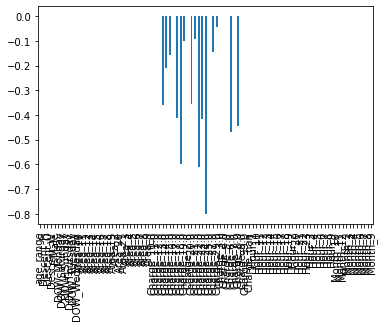

In [22]:
# Look at the weights for linear SVM
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')

In [23]:
weights.sort_values()

Charge_24.0   -0.80
Charge_22.0   -0.61
Charge_18.0   -0.60
Charge_6.0    -0.47
Charge_8.0    -0.45
               ... 
Area_4         0.00
Area_17        0.00
Area_19        0.00
Hour_10        0.00
Area_12        0.00
Length: 93, dtype: float64

#### SVM Significant Linear Weights
There are many categories that have practically no weight at all(absolute value less than 0.0001). Filtering out values with abs < .01 takes us from 93 weights to 15.  The plot below shows this graphically and shows visually which weights do carry the greatest impact.

Only charge related categories remain after filtering for weights with an absolute value greater than 0.01, so we can infer that the excluded fields, hour, area, day of week, and even descent code, are all less useful than the charge type in finding the ideal separating hyperplane between the various types of arrests. However, this may be a reflection of the data, which contains significant overlap between certain charge types and arrest types. As an example, charge_4.0 is Aggravated Assault, which is almost always a Felony.

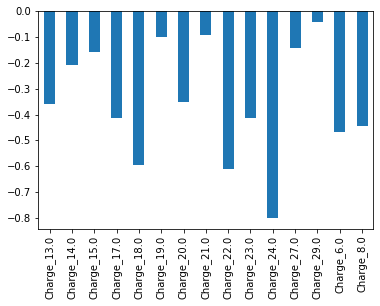

In [24]:
#filter and regraph
weights = pd.Series(svm_clf.coef_[0],index=df.columns)
weights_filtered = weights[abs(weights) > 0.01]
len(weights_filtered)
weights_filtered.plot(kind='bar')

#### SVM Polynomial Kernel
Next, we use the polynomial kernel, which allows us to learn a non-linear model.  We can specify the degree (i.e. the highest number of exponents of the polynomial).  In this case, we chose to go with 3.  While higher order polynomials would result in better accuracy, they would likely overfit the model, thus making it a poor predictor.

Once fit, we look at the test results and find that this model results in about 81% accuracy.  This is significantly better than the accuracy results from logistic regression.

In [27]:
%%time
#poly test
svm_clf = SVC(C=0.5, kernel='poly', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('Poly SVM Accuracy:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

Poly SVM Accuracy: 0.8094525968159018
precision 0.7894506067203265
recall 0.8094525968159018
[[ 7694  2858     0     0]
 [ 1987 18061    74     0]
 [   27   447   226     0]
 [   35   688     0     0]]
Wall time: 1h 19min 25s


#### Stochastic Gradient Descent
Just to see what the differences might be, we also tried a model with SGD.  Much like SVM, this also involved the use of some scaling before getting the test set prediction.  The results and confusion matrix show that accuracy with this method was as good as with SVM using and RBF kernel.  While performance in this analysis was very similar for both models, using SGD could result in better performance since it doesn't explode exponentially the way that the SVM algorithm does.

In [30]:
%%time
# Linear SVM classifier with Stochastic Descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()

svm_sgd.fit(scl.fit_transform(X_train_scaled),y_train)
yhat = svm_sgd.predict(scl.transform(X_test_scaled))

svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('SVM w/Stochastic Descent:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

SVM w/Stochastic Descent: 0.8095712861415753
precision 0.7904565683291602
recall 0.8095712861415753
[[ 7747  2744     0     0]
 [ 2133 17984    51     0]
 [   32   432   253     0]
 [   40   680     0     0]]
(62057, 93)
(62057,)
[24301 32489  2440  2827]
Wall time: 1h 29min 29s


#### SVM Radial Basis Function Kernel
For our final SVM model, we use RBF, which, much like sigmoid, ranges between 0 and 1.  It measures the distance between points and the support vectors, and another useful property is that RBF decreases with distance.  The result is an accuracy 81.12%.

In [22]:
%%time
# train the model just as before with an rbf kernal
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

print('RBF SVM Accuracy:', mt.accuracy_score(y_test,y_hat))
print("precision", mt.precision_score(y_test,y_hat,average='weighted'))
print("recall", mt.recall_score(y_test,y_hat,average='weighted'))
print(mt.confusion_matrix(y_test,y_hat))

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

RBF SVM Accuracy: 0.8095712861415753
precision 0.7904565683291602
recall 0.8095712861415753
[[ 7747  2744     0     0]
 [ 2133 17984    51     0]
 [   32   432   253     0]
 [   40   680     0     0]]
(62057, 93)
(62057,)
[24301 32489  2440  2827]
Wall time: 1h 15min 50s


#### SVM Winning Model
`Table 3` summarizes model performance for the SVM models we ran. About 81% accuracy for kernel types RBF and Poly. On this dataset, polynomial appears to take most time/computational resources with sigmoid the least. The RBF (gaussian) approach is slightly more accurate than the rest, which may indicate that the ideal separating hyperplane that can be used to categorize arrest type codes is nonlinear.

#### Table 3: SVM Model Performance

| Model | Time HH:MM:SS | Accuracy | Precision | Recall |
| :-- | :-- | :-- | :-- | :-- |
| Stochastic Descent (rbf kernel) | 1:29:29 | 80.96% | 79.05% | 80.96% |
| **Linear SVM (rbf kernel)** | 1:15:50 | **80.96%** | **79.05%** | **80.96%** |
| Polynomial SVM | 1:19:25 | 80.95% | 78.95% | 80.95 | 
| Linear SVM | 1:06:26 | 80.49% | 76.86% | 80.49% |
| Sigmoid SVM | 31:38 | 74.25% | 71.22% | 74.25% |

<a href='#Section_A'> Back to top </a>
<a id = 'Section_4'></a>

## 4. Model Advantages

#### Logistic Regression

- **Advantages**: Simple and interpretable model. Can classify and also give you probabilites. Computationally inexpensive. Good baseline to compare more complex models. Easy to regularize (shrink coeffiicent estimates to zero to avoid overfitting).  


- **Disadvantages**: Performace suffers when there are multiple non-linear decision boundaries. 

For our dataset, the logistic regression model performed much worse than all SVM models. The logistic regression model was even built with more data than the SVM models. The computing time for our logistic regression models was significantly less than the SVM models.

#### Support Vector Machine

- **Advantages**: Highly accurate. Can model non-linear decision boundaries. Can work well on smaller datasets (i.e., doesn't need millions of observations). Generalizes well. Tends to avoid overfitting and works well when identifying boundary regions.     


- **Disadvantages**: Training time with SVMs can be high. Less effective on noisier datasets with overlapping classes. Requires selection of the kernel function parameters (i.e. you have to provide the true structure of the data as an input). Requires tuning the parameters for the kernels and the C parameter, which can be time consuming and decrease the performance if done improperly.  

For our dataset, the computing time required for SVM models was an issue. We wanted to test a wide variety of models, but when some of them take hours to run (on just 15% of the data), we were limited in what we could actually acoomplish. We spent days trying to get the full dataset to run through an SVM model before we had to give up and sample the dataset. The advantage of the SVM models for our dataset was the huge gain in accuracy. The logistic regression models were not accurate enough, in our opinion, to actually be useful.

<a href='#Section_A'> Back to top </a>
<a id = 'Section_5'></a>

## 5. Feature Importance

Below we re-run the winning logistic regression model.

In [17]:
%%time

lr_clf = LogisticRegression(multi_class='multinomial', C=.5, penalty='l2', solver='lbfgs',random_state=1234, class_weight='balanced')
yhat=np.zeros(y.shape)
std_scl = StandardScaler()

# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

# run the pipline crossvalidated
for train, test in cv_object2.split(X,y):
    piped_object.fit(X[train],y[train])  # train object
    yhat[test] = piped_object.predict(X[test])

# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']
print("confusion matrix\n",mt.confusion_matrix(y,yhat))
print("accuracy", mt.accuracy_score(y,yhat))
print("precision", mt.precision_score(y,yhat,average='weighted'))
print("recall", mt.recall_score(y,yhat,average='weighted'))

confusion matrix
 [[286161  40424   2781  56563]
 [ 86899 404041 114731 125631]
 [  1141   2518  21867    490]
 [     6    447      1  25533]]
accuracy 0.6308420726732202
precision 0.8234263681190657
recall 0.6308420726732202
Wall time: 11min 46s


Here we sort the weights by absolute value and print out the coefficients.

In [18]:
# sort these attributes and spit them out
zip_vars = zip(trained_model_from_pipeline.coef_[0],df_logreg.columns) # combine attributes
zipped = list(zip_vars) 
zipped = sorted(zipped,key = lambda t: np.abs(t[0]), reverse=True)
for coef, name in zipped:
    print(name, 'has weight of', coef) # now print them out

Charge_18.0 has weight of -3.252680325992733
Charge_24.0 has weight of -2.200185152533388
Charge_17.0 has weight of -2.111784260887198
Charge_20.0 has weight of -1.0963344185323487
Charge_4.0 has weight of 0.7092765172921349
Charge_23.0 has weight of -0.6906882258110281
Charge_27.0 has weight of -0.6569760238017431
Charge_19.0 has weight of -0.5157169686130001
Charge_6.0 has weight of -0.4844920699347422
Charge_12.0 has weight of 0.47715589575203243
Charge_8.0 has weight of 0.37967432589802774
Charge_16.0 has weight of -0.3717382173552889
Charge_7.0 has weight of 0.34111195464090427
Charge_5.0 has weight of 0.3400158612624107
Charge_13.0 has weight of -0.2831856850707837
Charge_14.0 has weight of 0.26104987801626683
Charge_9.0 has weight of 0.24242355956315995
Charge_11.0 has weight of 0.23053454255692168
Area_15 has weight of -0.16726008950318857
Area_13 has weight of 0.13455258584059188
Charge_29.0 has weight of -0.13286792426747057
Area_16 has weight of 0.13264992752446755
Charge_22

The plot below displays the most important features in the logistic regression model. We used a cut-off of .1 for the absolute value of the weights. This is due to the large number of explanatory variables, and the fact that the majority of them have weights very close to zero.

(-2.5, 29.840000000000003)

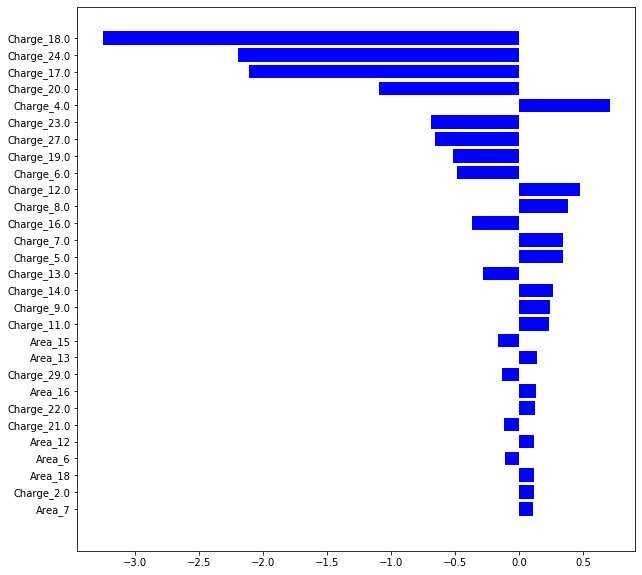

In [19]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(trained_model_from_pipeline.coef_[0],index=df_logreg.columns)
weights_filter = weights[weights.abs() >= 0.1]
weights_final = weights_filter.iloc[weights_filter.abs().argsort()]

x = weights_final.index
y = weights_final.values

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(x,y, color='blue')
#ax.margins(0.05)
ax.set_ylim(bottom=-2.5)

Per the Logistic Regression Feature Importance chart above, we can see that the six most important features are Charge_18 (Drunkeness), Charge_24 (Misc Other Violations), Charge_17 (Liquor Laws), Charge_20 (Disorderly Conduct), Charge_4 (Aggravated Assault), and Charge_23 (Moving Traffic Violations). 

The only 2 original variables that show up in the top weights are related to `Charge Group Code` and `Area ID`. Surprisingly, we don't see any variables for gender, descent or age.

Since all explanatory variables are continuous, we have only interpreted in detail 2 of the most important features (a negative and positive weight coefficient). All other weights would follow the same interpretation pattern.
* The odds ratio of an incident being a felony when the charge group code is 18 (Drunkeness) relative to when it's not 18 is 0.03867. The odds of an incident being a Felony when the charge group code is 18 is 96.13% less than the odds when it isn't 18. Looking at the data, most of the incidents with charge group code of 18 are Misdemeanors.
* The odds ratio of an incident being a felony when the charge group code is 4 (Aggravated Assault) relative to when it's not 4 is 0.70928. The odds of an incident being a Felony when the charge group code is 4 is 2.3 times higher than the odds when it isn't 4. Looking at the data, most of the incidents with charge group code of 4 are Felonies.

Liquor related offenses were 70% misdemeanors and 30% infractions, with almost no felonies. Drunkeness related offenses were curiously seperate from liquor related ones, and consisted of 95% misdemeanors, 5% infractions, and no felonies. All of these charges correspond strongly to one or more arrest types, so it makes sense that these features are useful.

This does bring up possible overlap issues between certain charge types and arrest types. Some charge groups are almost completely uniform, such as charge 21, gambling, which is 99.5% misdemeanors. However, such charge groups are also very small, making up only about .2% of the arrest data. While the uniformity of arrest types is not as absolute for the largest categories, it does lean strongly in certain directions. It's not quite a one to one/directly correlated variable to target classification variable, but it might be too close to be useful.  

<a href='#Section_A'> Back to top </a>
<a id = 'Section_6'></a>

## 6. Interpretation of Support Vectors

To look at the support vectors for the winning RBF model, we need to first do some data prep by creating a fresh copy of the dataset and adding back in our arrest type code (the predicted variable).  This will allow us to perform some "before" and "after" comparisons on the support vectors and their base data.

In [23]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors
# make a dataframe of the training data
df_tested_on = df_svm1.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['Arrest Type Code'] = y[svm_clf.support_] # add back in the 'Arrest Type Code' Column to the pandas dataframe
df_svm1['Arrest Type Code'] = y # also add it back in for the original data

With our model and prepared data in hand, we can now compare the original data with the support vectors that were chosen. We do this by plotting all of the plottable features in the dataset and excluding a few, like the predicted feature, age range, and charge codes that do not contribute anything to the model or our understanding.

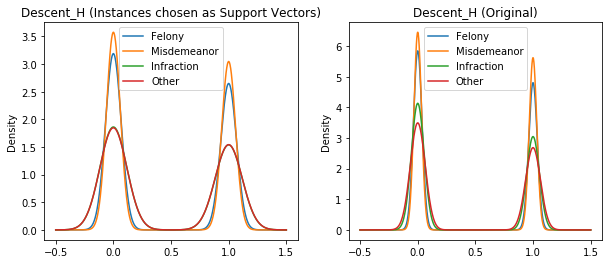

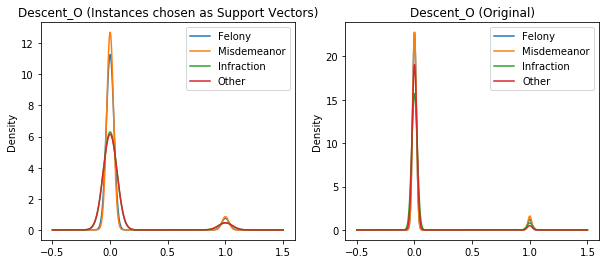

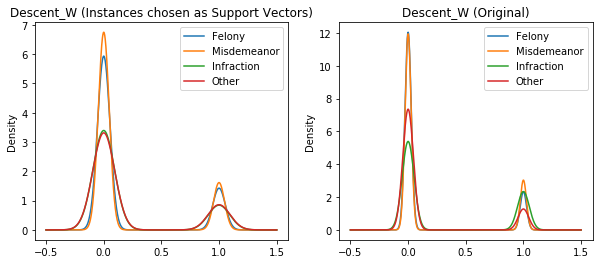

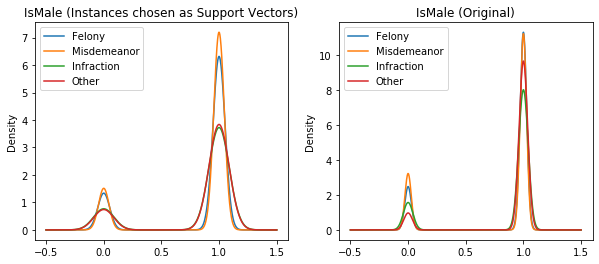

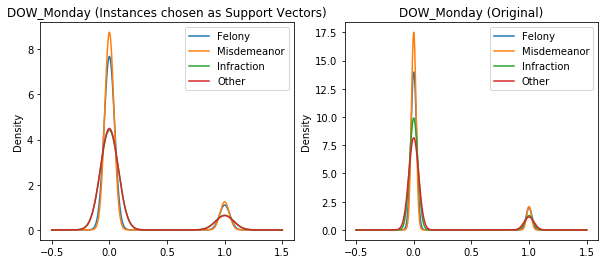

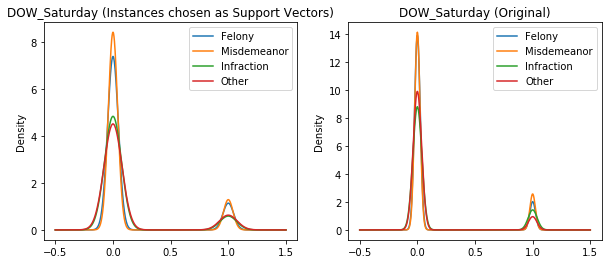

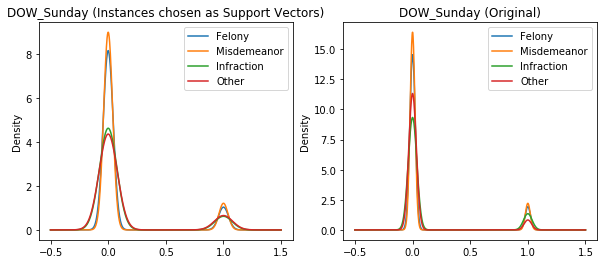

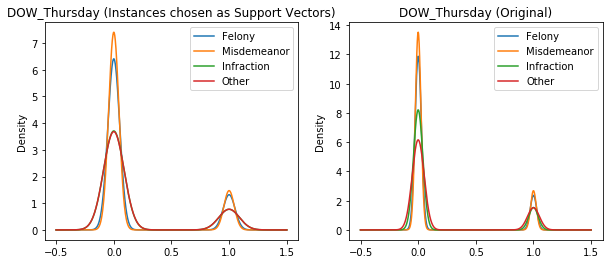

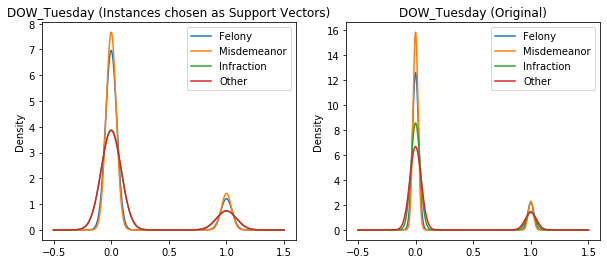

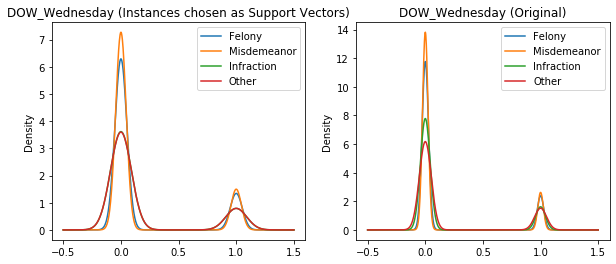

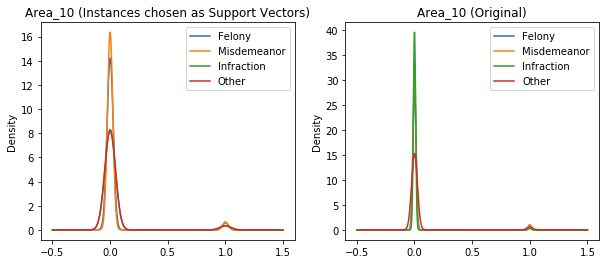

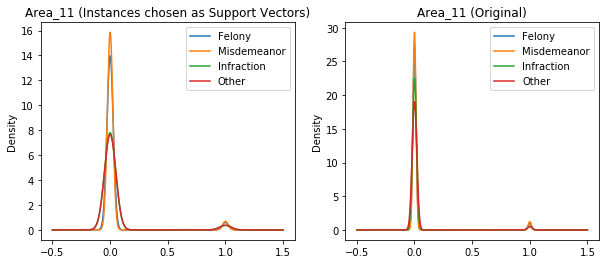

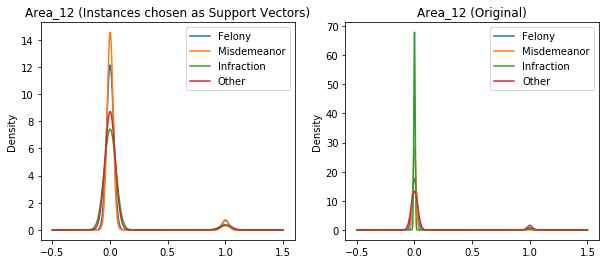

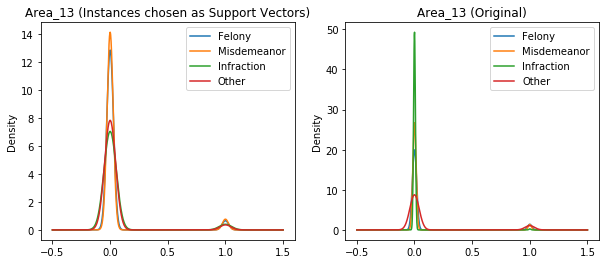

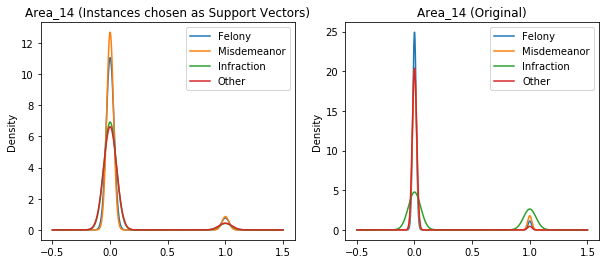

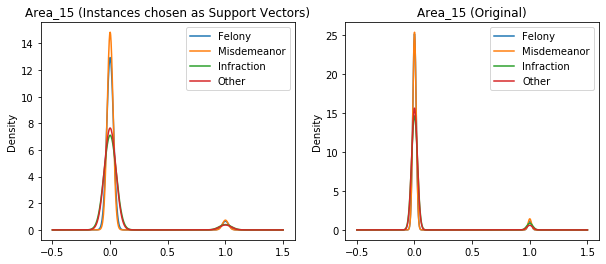

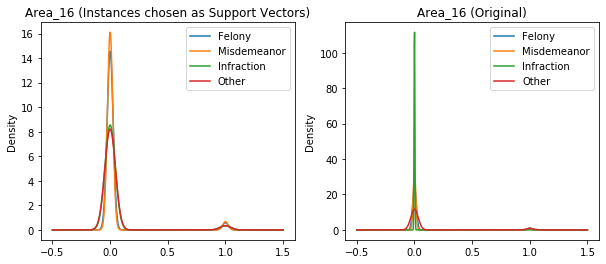

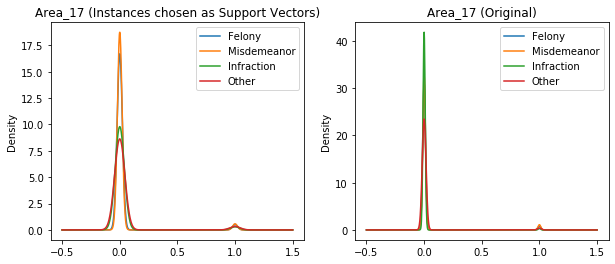

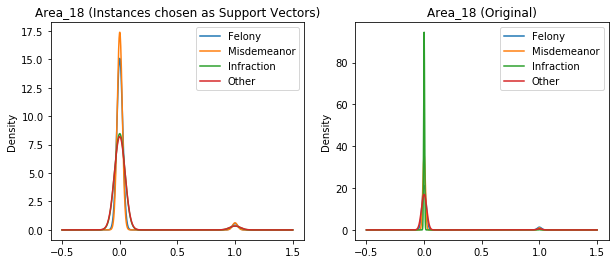

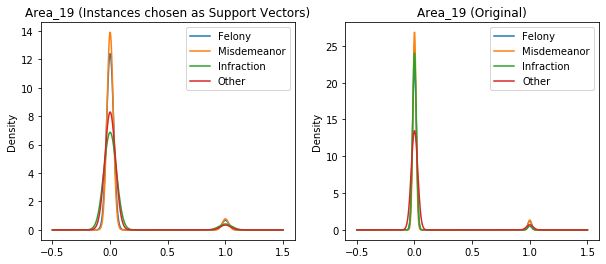

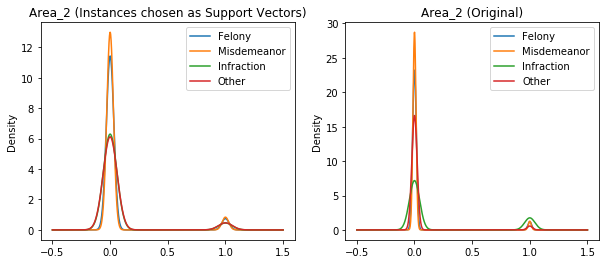

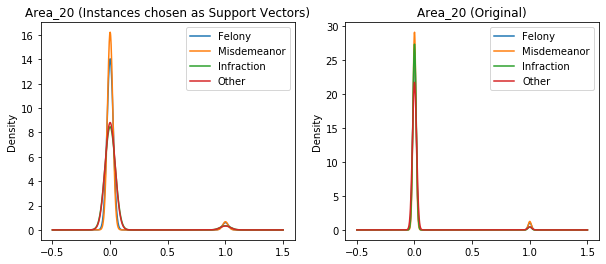

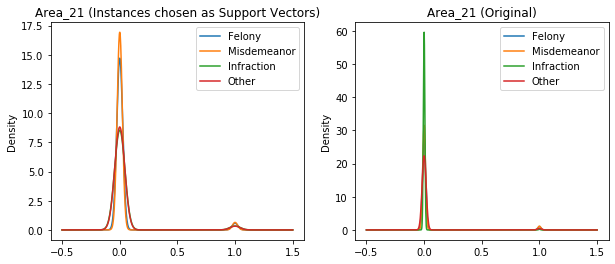

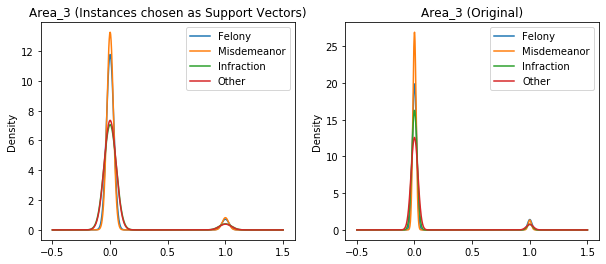

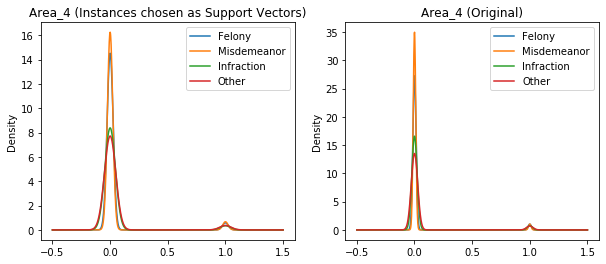

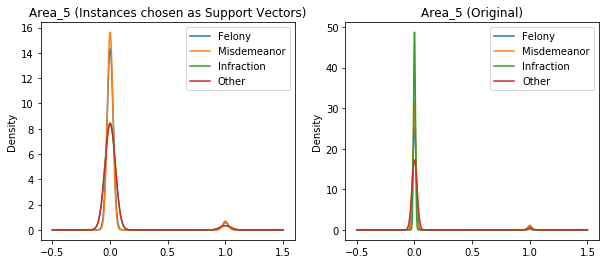

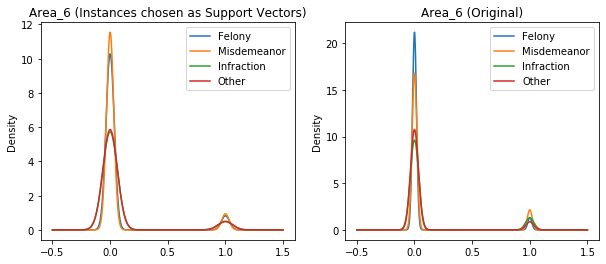

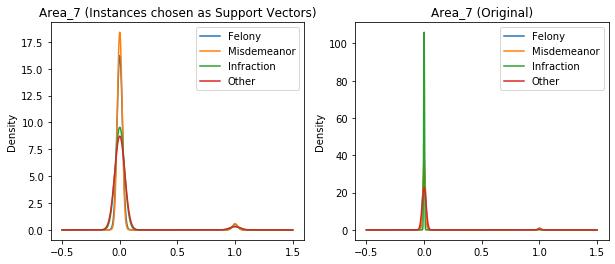

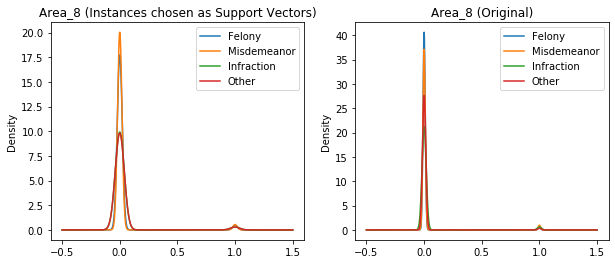

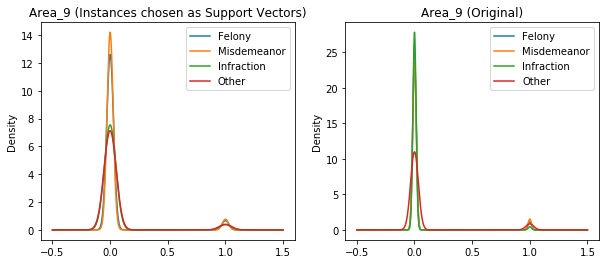

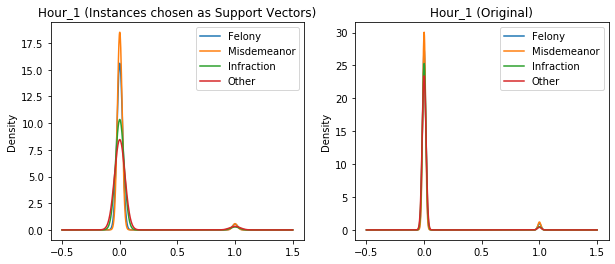

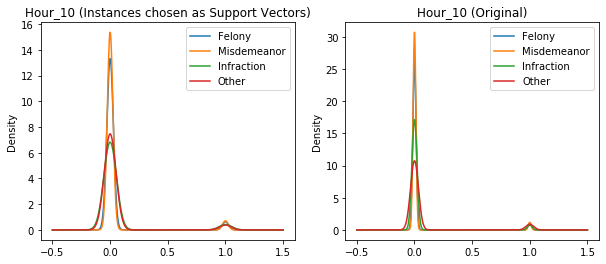

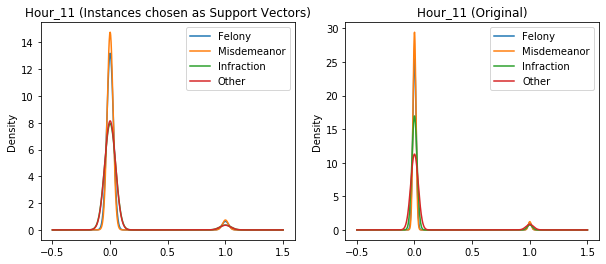

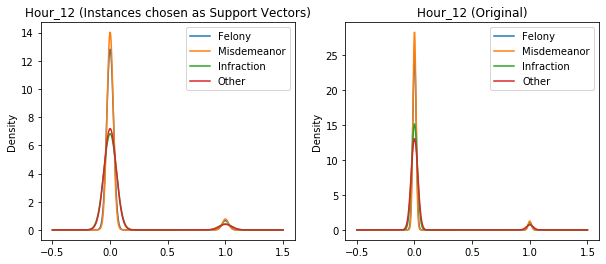

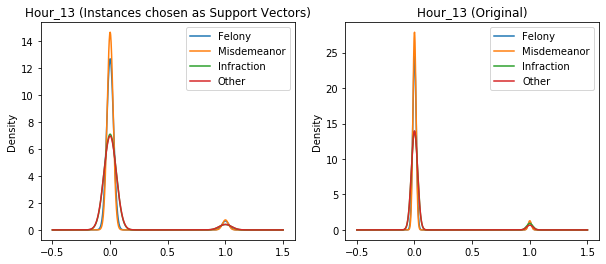

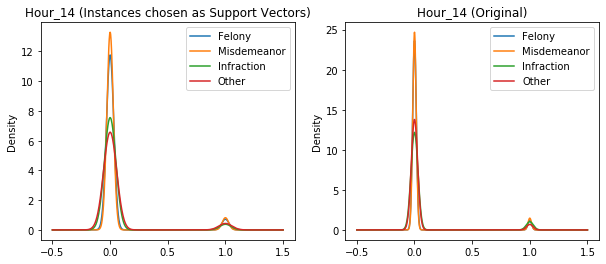

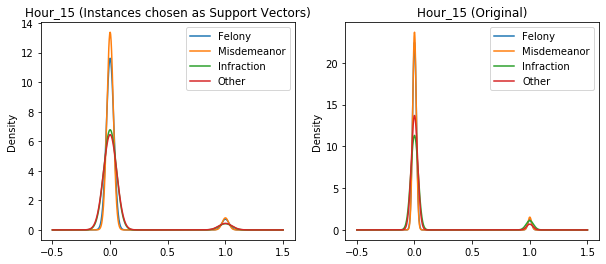

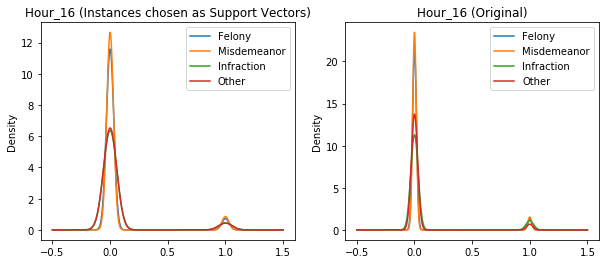

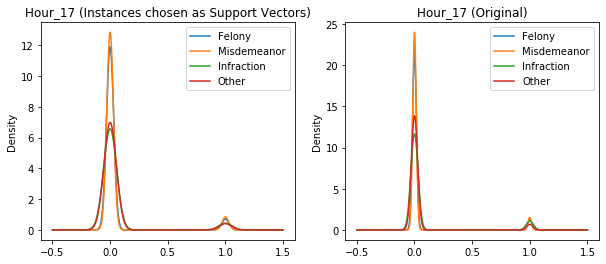

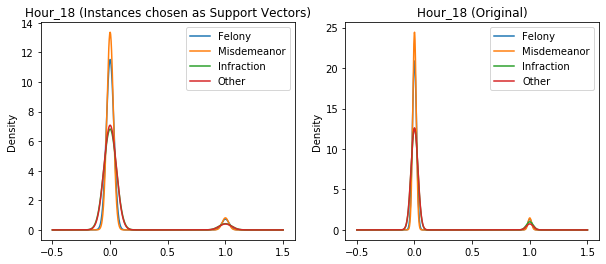

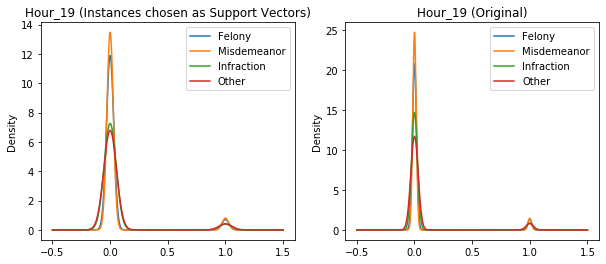

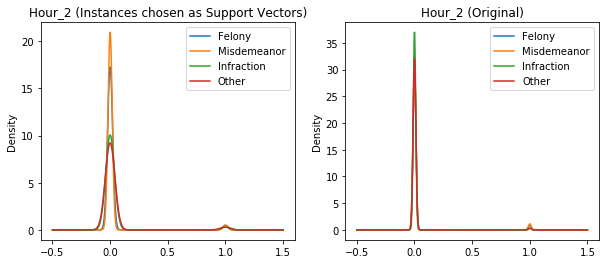

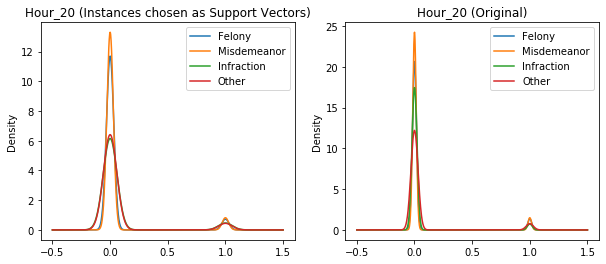

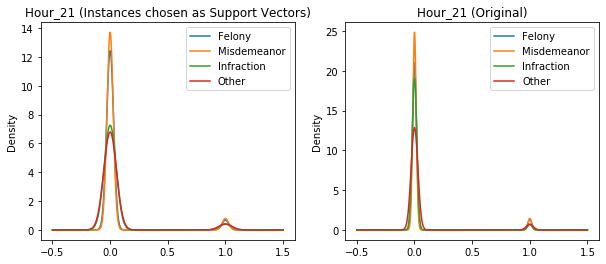

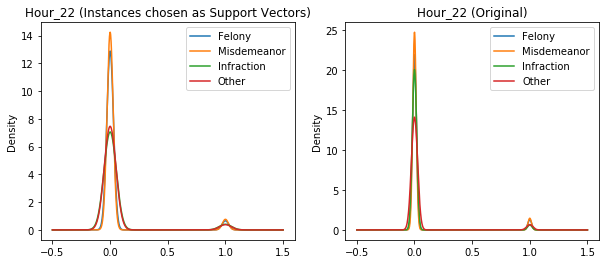

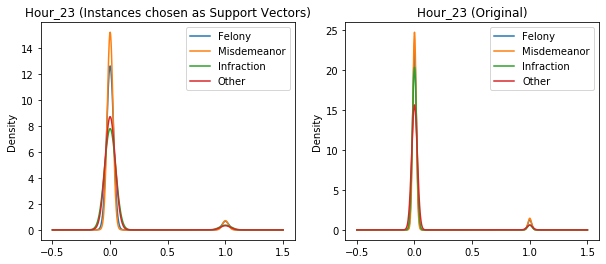

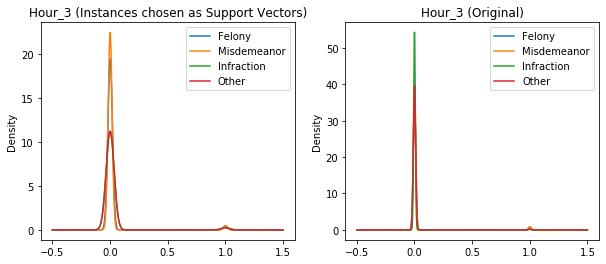

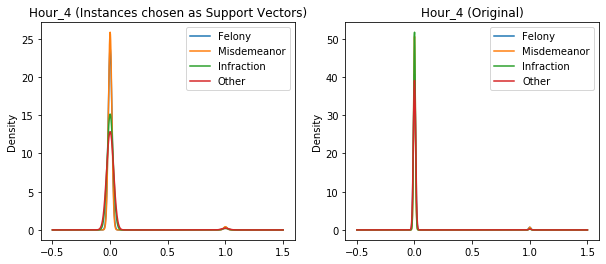

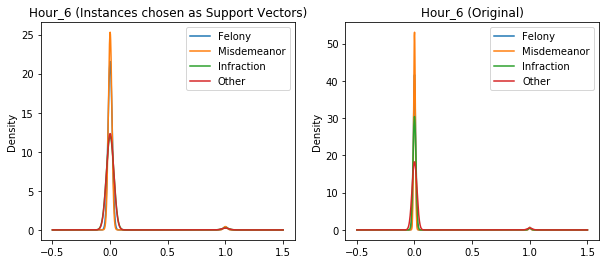

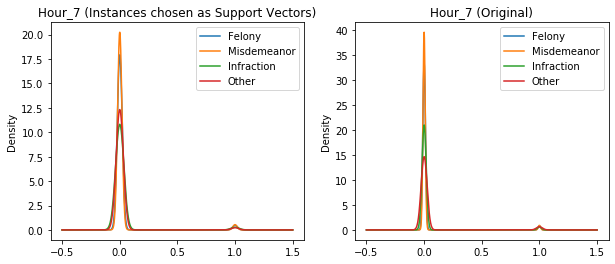

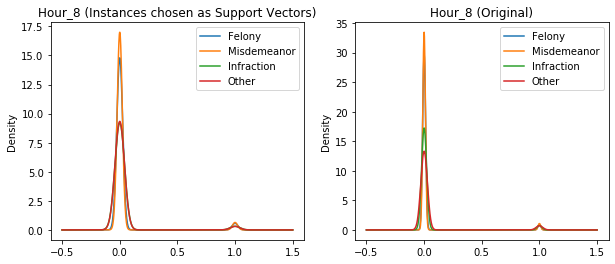

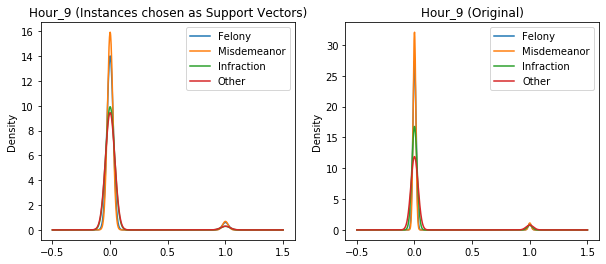

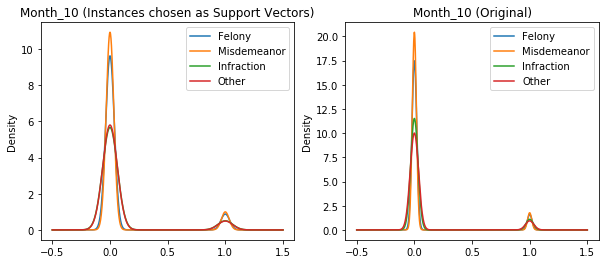

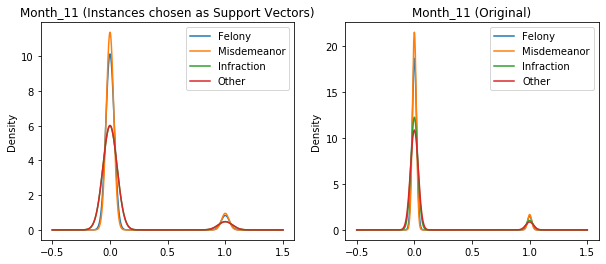

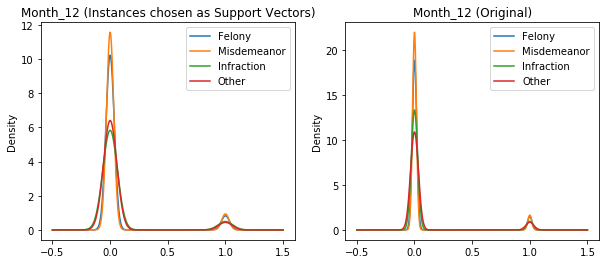

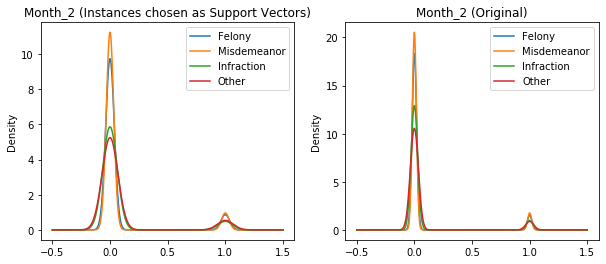

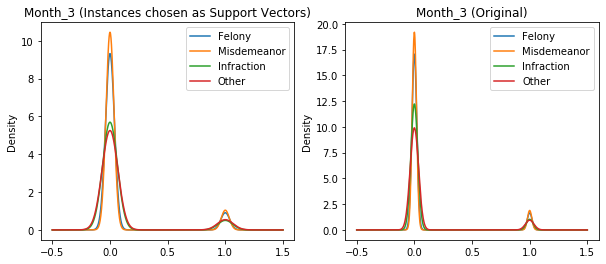

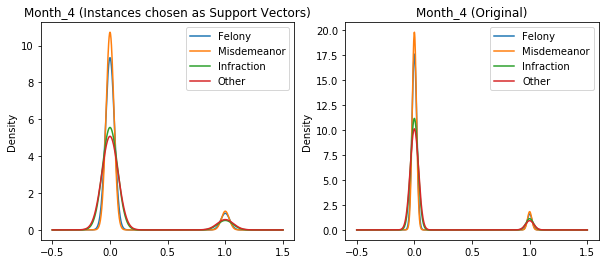

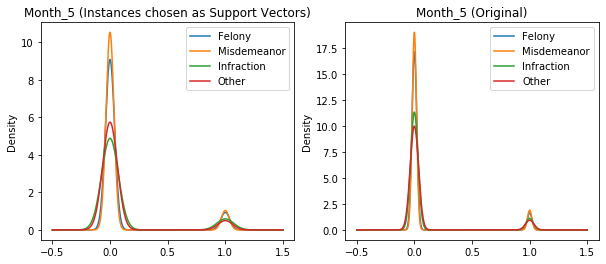

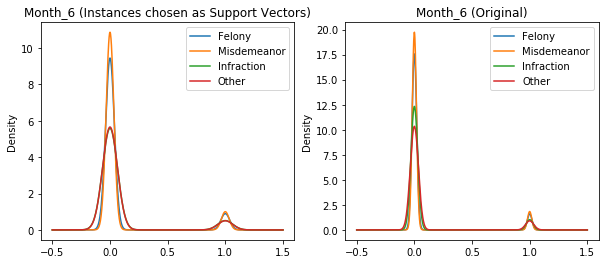

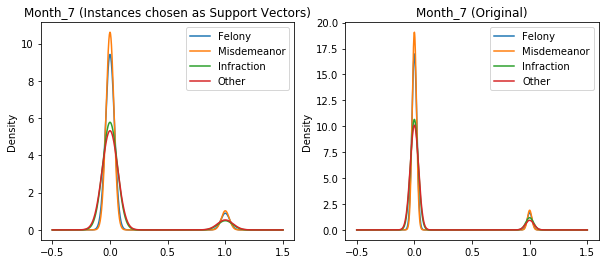

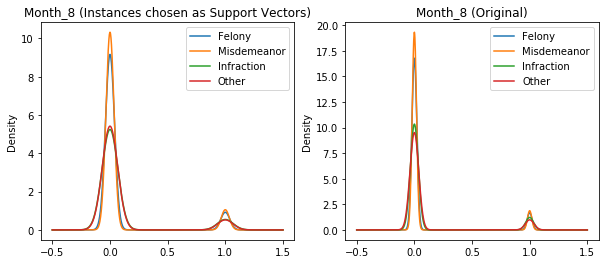

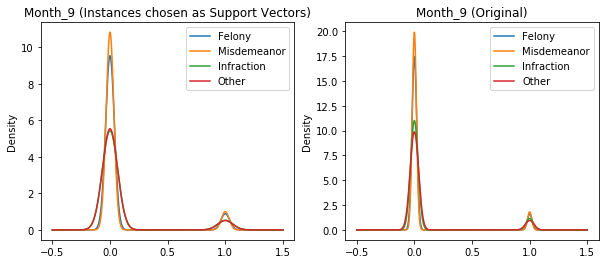

In [29]:
from pandas.plotting import boxplot

# Group the original data and the support vectors
df_grouped_support = df_support.groupby(['Arrest Type Code'])
df_grouped = df_svm.groupby(['Arrest Type Code'])

# Plot KDE of Different variables
vars_to_plot = df_support.columns.tolist()
vars_to_plot.pop()  # Drop last feature, arrest type code, it would make no sense to plot
vars_to_plot.pop(0) # Drop first feature, age_range, which makes no sense in this plot
vars_to_plot = list(filter(lambda item: ('Charge_' not in item) &  
                                        ('Hour_5' not in item), vars_to_plot))
for v in vars_to_plot:
    try:
        plt.figure(figsize=(10,4))
        # plot support vector stats
        plt.subplot(1,2,1)
        ax = df_grouped_support[v].plot.kde() 
        plt.legend(['Felony','Misdemeanor','Infraction','Other'])
        plt.title(v+' (Instances chosen as Support Vectors)')

        # plot original distributions
        plt.subplot(1,2,2)
        ax = df_grouped[v].plot.kde() 
        plt.legend(['Felony','Misdemeanor','Infraction','Other'])
        plt.title(v+' (Original)')
    except:
        continue  # If a feature isn't plottable, just ignore it and move on

<a href='#Section_A'> Back to top </a>

The support vectors show a generally reduced density and a flattening of the curve for each type of arrest code. Please note that the plot scales vary slightly; this can give the impression that some densities are greater when that is usually not the case.

Another interesting thing to note is that the separation between the distributions in the support vectors is not as great as between the orignal data. This is because support vectors tend to be along the boundaries between clusters, and they can also be affected by outliers.

The support vectors revealed that certain charge codes were highly predictive in determing what the arrest code would be.  This is what you might expect given that if someone is arrested for, say, murder, the resulting classification would, of course, be a felony.  Other features did not provide nearly as much insight, at least as far as the support vectors are concerned.  These include such things as the age, area, and various time-related features, which is a somewhat surprising result.

Support vector and gradient descent resulted in very similar accuracy, which was also a surprise.  We thought that support vectors would beat gradient descent easily, but this was not the case here.  It may be true in other instances, however, so it would be best to always check both types as well as looking at the various types of SVM kernels to identify the most appropriate model to use.

Similar to in the logistic regression model, there were several variables that we thought would be of more importance such as descent, gender and age. Instead we found that `Charge Group Code` and `Area ID` variables have the highest importance.